In [2]:
import numpy as np
import gym
from gym import spaces, logger
from gym.utils import seeding
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# VM Packing

This model is a multi-dimensional bin packing model that will provide a more challenging RL environment to learn with. The algo needs to minimize the number of VM's while managing both CPU and memory constraints across identical physical machines in a data center. The demand will be generated stochastically based on actual VM traces from Azure. There will be two versions, one with permanent packing and a second with temporary packing as VM's get removed some service.

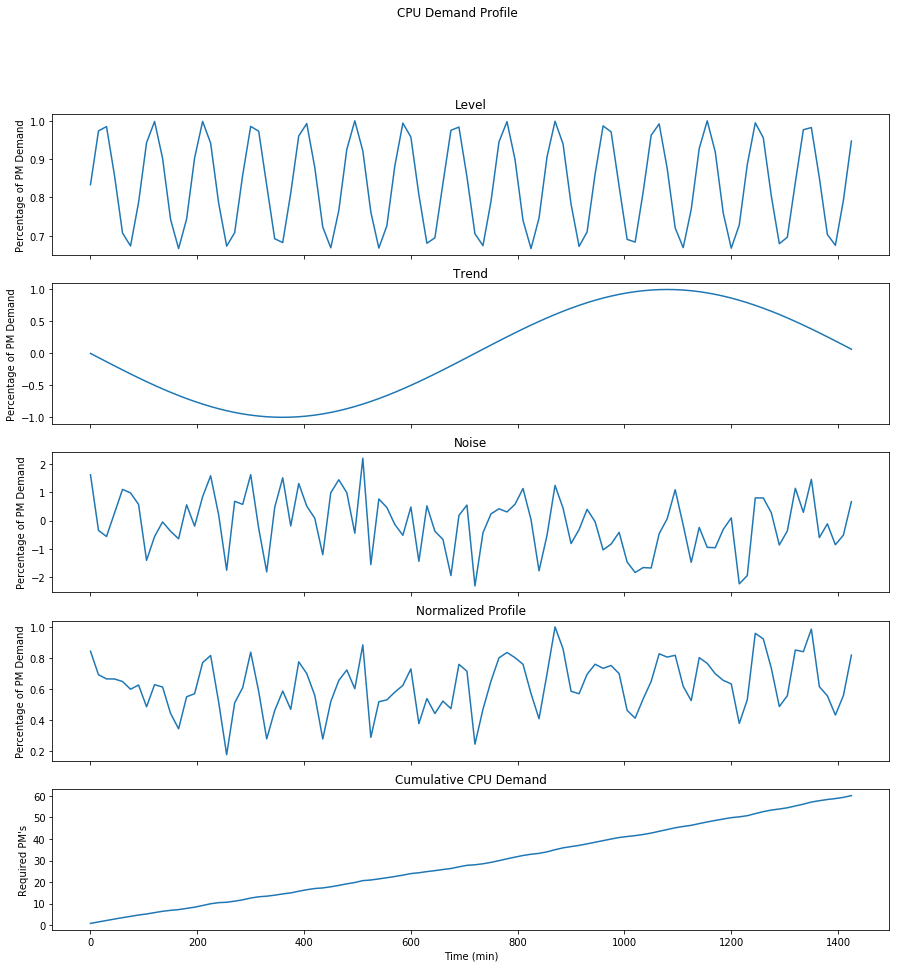

In [57]:
# Placeholder CPU demand model
t_int = 15
n_steps = int(1440 / t_int) # 1 day, 15 minute intervals
steps = np.arange(n_steps)
level = np.abs(np.sin(steps) + 5)
noise = np.random.normal(size=n_steps)
trend = np.sin(steps / n_steps * 2*np.pi + np.pi)
x = level + noise + trend
x /= x.max()

fig, ax = plt.subplots(5, 1, figsize=(15,15), sharex=True)

ax[0].plot(steps*t_int, level/np.max(level))
ax[0].set_title('Level')
ax[0].set_ylabel('Percentage of PM Demand')

ax[1].plot(steps*t_int, trend)
ax[1].set_title('Trend')
ax[1].set_ylabel('Percentage of PM Demand')

ax[2].plot(steps*t_int, noise)
ax[2].set_title('Noise')
ax[2].set_ylabel('Percentage of PM Demand')

ax[3].plot(steps*t_int, x)
ax[3].set_title('Normalized Profile')
ax[3].set_ylabel('Percentage of PM Demand')

ax[4].plot(steps*t_int, np.cumsum(x))
ax[4].set_title('Cumulative CPU Demand')
ax[4].set_xlabel('Time (min)')
ax[4].set_ylabel("Required PM's")

plt.suptitle('CPU Demand Profile')
plt.show()

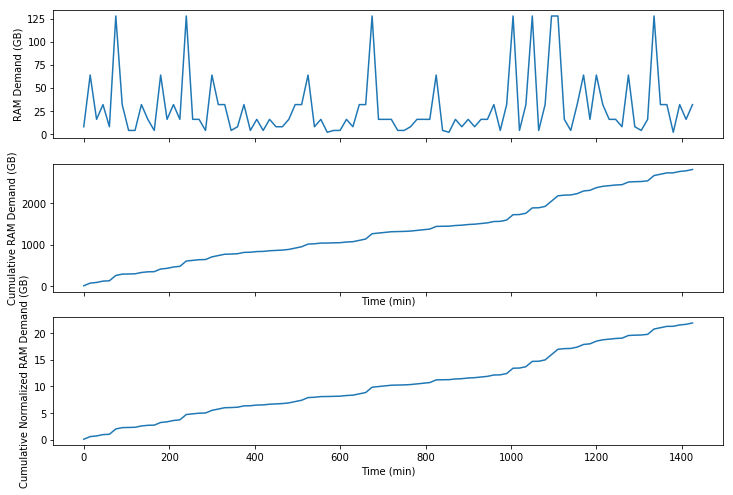

In [73]:
# Placeholder RAM demand model
t_int = 15
n_steps = int(1440 / t_int) # 1 day, 15 minute intervals
steps = np.arange(n_steps)

ram_levels = np.array([2, 4, 8, 16, 32, 64, 128])
# Assume levels are poisson distributed around 3 with each 
# value mapping to one of the levels
x = np.random.poisson(lam=3, size=n_steps)
ram_profile = [ram_levels[i] if i < len(ram_levels) else max(ram_levels) for i in x]

fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True)

ax[0].plot(steps*t_int, ram_profile)
ax[0].set_ylabel('RAM Demand (GB)')

ax[1].plot(steps*t_int, np.cumsum(ram_profile))
ax[1].set_ylabel('Cumulative RAM Demand (GB)')
ax[1].set_xlabel('Time (min)')

ax[2].plot(steps*t_int, np.cumsum(ram_profile / max(ram_levels)))
ax[2].set_ylabel('Cumulative Normalized RAM Demand (GB)')
ax[2].set_xlabel('Time (min)')
plt.show()

In [69]:
# Placeholder demand generation function
def generate_demand():
    t_int = 15
    n_steps = int(1440 / t_int) # 1 day, 15 minute intervals
    steps = np.arange(n_steps)
    level = np.abs(np.sin(steps) + 5)
    noise = np.random.normal(size=n_steps)
    trend = np.sin(steps / n_steps * 2*np.pi + np.pi)
    cpu_demand = level + noise + trend
    cpu_demand /= cpu_demand.max()
    
    ram_levels = np.array([2, 4, 8, 16, 32, 64, 128])
    # Assume levels are poisson distributed around 3 with each 
    # value mapping to one of the levels
    ram_sample = np.random.poisson(lam=3, size=n_steps)
    ram_demand = np.array([ram_levels[i] / max(ram_levels) 
        if i < len(ram_levels) else max(ram_levels) 
        for i in ram_sample])
    return np.vstack([cpu_demand, ram_demand]).T

In [ ]:
# Build VM Packing MDP
class VMPackingEnv(gym.Env):
    
    def __init__(self):
        # Normalized Capacities
        self.cpu_capacity = 1
        self.ram_capacity = 1
        self.step_limit = 60 * 24 / 15
        self.n_pms = 100 # Number of physical machines to choose from
        
        self.observation_space = 0
        self.action_space = spaces.Discrete()
        self.state = self.reset()
        
    def step(self, action):
        pass
    
    def reset(self):
        self.step_count = 0
        self.demand = generate_demand()
        state = None
        return state